In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 90 degree rotation group.
# + mod 4.
G = [
    np.array([[1, 0], 
              [0, 1]]),
    np.array([[0, 1], 
              [-1, 0]]),
    np.array([[-1, 0], 
              [0, -1]]),
    np.array([[0, -1], 
              [1, 0]]),
]

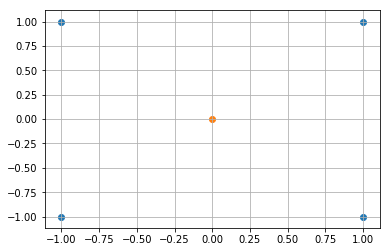

In [12]:
x = np.hstack([np.dot(g, np.array([[1],[1]])) for g in G])
plt.scatter(x[0,:], x[1,:])
plt.scatter(0,0)
plt.grid()

In [13]:
def is_closed(G):
    for i in range(len(G)):
        for j in range(len(G)):
            # for each possible combination of group elements
            k = np.dot(G[i], G[j])
            # does their combination result in another element in the group?
            closed = bool(sum([np.equal(k, g).all() for g in G]))
            if not closed:
                return False
    return True

is_closed(G)

True

In [25]:
def orbit(x, G):
    """
    Args:
        x (np.array): x.shape = [B, D]
        G (list): a representation of the group in GL(D). len(G) = n
        
    Returns:
        (np.array): [B x n, D]
    """
    return np.stack([np.dot(g, x.T) for g in G]).T

In [26]:
x = np.random.standard_normal((1000, 2))
orbit(x, G).shape

(1000, 2, 4)

In [53]:
def nonlin(z, a):
    return 1/(1+np.exp(z-a))

def construct_weights(T, G):
    """
    Args:
        T (np.array): each row is a basis point. Q of them
        G (list): a list of representations in GL(d)
        
    Returns:
        W (np.array): [|T| x d x |G|]
    """
    return np.stack([orbit(t, G) for t in T])

def fn(W, x, n_a=10):
    """
    Args:
        W (np.array): [|T| x d x |G|]
        x (np.array): [B, d] the input datapoints
        
    Returns:
        (np.array): [B, |T|, n_a]
    """
    # [N(T) x num_dims x num_group] . [batch x num_dims] -> [batch x N(T)]
    h = np.einsum('ijk,lj->li', W, x)
    # batch x T x n_a
    y = np.stack([nonlin(h, a) for a in np.linspace(-3, 3, n_a)], axis=-1)
    return y

In [56]:
x = np.random.standard_normal((1000, 2))
T = x[0:100, :]
W = construct_weights(T, G)
y = fn(W, x[-20:,:])
print(y.shape)

(20, 100, 10)


In [344]:
def delta(x):
    z = np.equal(x, np.zeros_like(x)).astype(np.float32)
    return z  # np.abs(1-z)

def make_pairwise_diffs(d):
    n = (d**2) * ((d**2) - 1) // 2
    C = np.zeros((n, d**2))
    tau = np.zeros((n,))
    count = 0
    for i in range(d**2):
        for j in range(d**2):
            if i < j:
                C[count, :] = np.eye(d**2)[i] - np.eye(d**2)[j]
                I = i % d
                J = j % d
                tau[count] = d*delta(I-J) - 1
                count += 1
                                
    assert n == count
    return C,  tau

def permuted_columns(M):
    """
    Want to check that the representation has group structure.
    That it is closed!?!
    Want a differentiable regulariser.
    
    Args:
        M (np.array): shape = (d, d)
        
    Returns:
        (float): the 'soft' (??) measure of row permutation invariance
    """
    d = M.shape[0]
#     C, tau = make_pairwise_diffs(d)
#     vecM = np.reshape(M, -1)
#     return np.dot(tau.T, delta(np.dot(C, vecM)))

    # TODO this is v slow
    return np.sum([(d*delta(i-j) - 1) * delta(M[k, i] - M[l, j]) 
                  for i in range(d)
                  for j in range(d)
                  for k in range(d)
                  for l in range(d)])

In [386]:
W = np.random.standard_normal((4,4))
print(permuted_columns(W))


W = np.random.standard_normal((2,4))
print(permuted_columns(np.dot(W.T, W)))

M = np.array([
    [0, 1, 2],
    [1, 2, 0],
    [2, 0, 1]
])
print(permuted_columns(M))
# these dont change with rnd inits...?!?

48.0
36.0
0.0


In [413]:
# calc the inter distance
xs = np.random.standard_normal((10, 2))

#calc the intra distance
y_intra = fn(T, G, xs)
d_intra = permuted_columns(y_intra)

zs = np.stack([orbit(xs[i:i+1, :], G) for i in range(xs.shape[0])], axis=0)
y_inters = np.stack([fn(T, G, zs[i]) for i in range(xs.shape[0])], axis=0)

# should be invariant to the group now!?
d_inter = np.stack([permuted_columns(y_inters[i]) for i in range(xs.shape[0])], axis=0)

In [414]:
d_intra, d_inter
# BUG d_inter should be zero tho?!?

(900.0, array([ 96., 192., 108., 126., 156., 174., 138., 126., 168., 132.]))

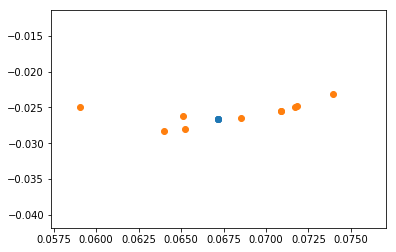

In [415]:
# rnd projection down to 2d.
P = np.random.standard_normal((1000, 2))
p1 = np.dot(y1, P)/1000
p2 = np.dot(y2, P)/1000

plt.scatter(p1[:, 0], p1[:, 1])
plt.scatter(p2[:, 0], p2[:, 1])

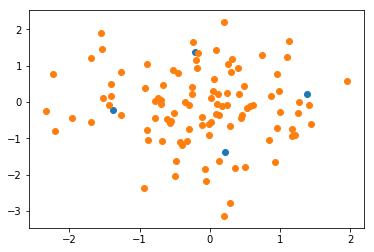

In [385]:
plt.scatter(z[:, 0], z[:, 1])
plt.grid()

plt.scatter(T[:, 0], T[:, 1])
plt.grid()

In [18]:
def commutator(A, B):
    """
    Want more intuition about this.
    When does this equal zero? For what type of matrix?
    Ones that share eigenspaces. But what does that mean...?
    """
    return np.dot(A, B) - np.dot(B, A)

In [28]:
A = np.random.standard_normal((4,4))

# make another matrix with the same engienspace
U, S, Vt = np.linalg.svd(A)
B = np.dot(np.dot(U, np.diag(2*S)), Vt)

r = commutator(A, B)
print(np.isclose(r, np.zeros_like(r)).all())

True


In [35]:
A = np.random.standard_normal((4,4))
noise = 0.00000000001*np.random.standard_normal((4,4))
# a small amount of noise pushes it away from being zero

# make another matrix with approximately the same engienspace
U, S, Vt = np.linalg.svd(A)
B = np.dot(np.dot(U+noise, np.diag(S)), Vt)

r = commutator(A, B)
print(np.isclose(r, np.zeros_like(r)).all())

True


In [36]:
A = np.random.standard_normal((4,4))
B = np.random.standard_normal((4,4))

r = commutator(A, B)
print(np.isclose(r, np.zeros_like(r)).all())

False
